In [1]:
import importlib
import argparse
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve


%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm

In [4]:
sys.path.insert(0, './../utils/')
from utils import *
from models import *

In [5]:
#Define parser
#name = 'bpi_2012'
name = 'bpi_2013'

parser = {
    'train': True,
    'test': True,
    'model_class': 'LSTMAE',
    'model_name': '',
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'anomaly_pct': 0.1,
    'input_dir': '../input/{}/'.format(name), 
    'batch_size' : 16,
    'epochs' : 10,
    'no_cuda' : False,
    'seed' : 7,
    'layer1': 100,
    'layer2': 100,
    'lr': 0.002,
    'betas': (0.9, 0.999),   
    'lr_decay': 0.90,
}

args = argparse.Namespace(**parser)
args.output_dir = './output/{0}_{1}_{2}/'.format(name, args.anomaly_pct, args.model_class)

In [6]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

In [7]:
args.cuda = not args.no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

In [8]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [9]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    activity_label_train = pickle.load(f)
    activity_label_val = pickle.load(f)
    activity_label_test = pickle.load(f)
    time_label_train = pickle.load(f)
    time_label_val = pickle.load(f)
    time_label_test = pickle.load(f)
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    mean_value = pickle.load(f)
    std_value = pickle.load(f)
    cols = pickle.load(f)
    statistics_storage = pickle.load(f)

# Load data

In [10]:
#train
input_trainLoader = torch.utils.data.DataLoader(input_train, batch_size=args.batch_size, shuffle=False, num_workers=2)
pad_index_trainLoader = torch.utils.data.DataLoader(pad_index_train, batch_size=args.batch_size, shuffle=False, num_workers=2)

In [11]:
#test
normal_df_name = os.path.join(args.input_dir, 'normal_df_{}.csv'.format(args.anomaly_pct))
normal_df = pd.read_csv(normal_df_name)

anomalous_df_name = os.path.join(args.input_dir, 'anomolous_df_{}.csv'.format(args.anomaly_pct))
anomalous_df = pd.read_csv(anomalous_df_name)

In [12]:
caseid_test = normal_df['CaseID'][-test_row_num:]

#normal class
true_activity_test = normal_df['Activity'][-test_row_num:]
true_cumduration_test = normal_df['CumDuration'][-test_row_num:]

#anomalous class
anomalous_activity_test = anomalous_df['AnomalousActivity'][-test_row_num:]
anomalous_cumduration_test = anomalous_df['AnomalousCumDuration'][-test_row_num:]

# Build model

## Define model

In [13]:
if args.model_class == 'LSTMAE':
    model = LSTMAE(input_train.shape[2], args.layer1, args.layer2, 1, args.cuda)

if args.cuda:
    model.cuda()

In [14]:
model.parameters

<bound method Module.parameters of LSTMAE (
  (encoder): EncoderRNN (
    (fc): Linear (8 -> 100)
    (lstm): LSTM(100, 100, batch_first=True)
  )
  (decoder): DecoderRNN (
    (lstm): LSTM(100, 100, batch_first=True)
    (fc): Linear (100 -> 8)
    (sigmoid): Sigmoid ()
  )
)>

## Define loss

In [15]:
def loss_function(recon_x, x, pad_index):
    MSE = F.mse_loss(recon_x, x, size_average=False) 
    #BCE = F.binary_cross_entropy(recon_x, x, weight=pad_index, size_average=False)
    return MSE

## Define optimizer

In [16]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=args.betas)

In [17]:
#Adjust learning rate per epoch: http://pytorch.org/docs/master/optim.html?highlight=adam#torch.optim.Adam

# Method 1:
lambda1 = lambda epoch: args.lr_decay ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

# Method 2:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

# Utils

In [18]:
def save_model(model, epoch, score):
    model_file = os.path.join(args.output_dir, 'model_{}_epoch{}_score{:.4f}.pth'.format(args.model_class, epoch, score))
    torch.save(model.state_dict(), model_file)

In [19]:
def load_model(model, model_name):
    model_file = os.path.join(args.output_dir, model_name)
    assert os.path.isfile(model_file), 'Error: no model found!'
    model_state = torch.load(model_file)
    model.load_state_dict(model_state)

In [20]:
def val(model, input_val, pad_index_val):
    model.eval()
    input_val = Variable(torch.Tensor(input_val).float())
    pad_index_val = Variable(torch.Tensor(pad_index_val).float())
    
    if args.cuda:
        input_val = input_val.cuda()
        pad_index_val = pad_index_val.cuda()
    
    recon_val = model(input_val)    
    loss = loss_function(recon_val, input_val, pad_index_val)
    return loss.data[0]/len(input_test.data)

# Train

In [21]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (batch_data, batch_index) in enumerate(zip(input_trainLoader, pad_index_trainLoader)):
        
        batch_data = Variable(batch_data.float())
        batch_index = Variable(batch_index.float())

        if args.cuda:
            batch_data = batch_data.cuda()
            batch_index = batch_index.cuda()
            
        optimizer.zero_grad()
        
        recon_data = model(batch_data)
        
        loss = loss_function(recon_data, batch_data, batch_index)
        
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        
    return train_loss / len(input_trainLoader.dataset)

In [22]:
if args.train:
    for epoch in range(1, args.epochs + 1):
        init = time.time()
        
        #method 1 scheduler
        scheduler.step()
        
        train_loss = train(epoch, model, optimizer)
        end_train = time.time()
        val_score = val(model, input_val, pad_index_val)
        
        #if epoch == 1:
        #    current_best = val_score
        #    save_model(model, epoch, val_score)
        
        #else:
        #    if val_score < current_best:
        #        current_best = val_score
        #        save_model(model, epoch, val_score)
        
        #method 2 scheduler
        #scheduler.step()
        
        end = time.time()
        print('====> Epoch {} | Train time: {:.4f} ms| End time: {:.4f} ms | Train loss: {:.4f} | Val score: {:.4f}'.
              format(epoch, (end_train-init)*1000, (end-init)*1000, train_loss, val_score))
else:
    load_model(model, args.model_name)

====> Epoch 1 | Train time: 8459.6961 ms| End time: 8788.4440 ms | Train loss: 14.1868 | Val score: 4.8373
====> Epoch 2 | Train time: 8360.8749 ms| End time: 8604.2790 ms | Train loss: 9.8656 | Val score: 4.3837
====> Epoch 3 | Train time: 6336.1118 ms| End time: 6596.7059 ms | Train loss: 8.6223 | Val score: 3.0025
====> Epoch 4 | Train time: 6427.8500 ms| End time: 6702.7972 ms | Train loss: 7.2798 | Val score: 2.3929
====> Epoch 5 | Train time: 7656.1210 ms| End time: 7937.9930 ms | Train loss: 5.5799 | Val score: 2.3151
====> Epoch 6 | Train time: 6759.7499 ms| End time: 7032.4850 ms | Train loss: 5.0677 | Val score: 2.1230
====> Epoch 7 | Train time: 8117.4400 ms| End time: 8398.3130 ms | Train loss: 4.5185 | Val score: 1.8718
====> Epoch 8 | Train time: 9031.6141 ms| End time: 9446.2550 ms | Train loss: 4.0455 | Val score: 1.7060
====> Epoch 9 | Train time: 7719.6491 ms| End time: 7988.7760 ms | Train loss: 3.7766 | Val score: 1.5981
====> Epoch 10 | Train time: 6527.4630 ms| En

# Predict

In [23]:
if args.test:
    input_test = Variable(torch.Tensor(input_test).float())
    if args.cuda:
        input_test = input_test.cuda()
    
    print('Predicting...')
    recon_test = model(input_test)
    
    print('Separating error for time and activity...')
    predicted_time, predicted_activity, true_time, true_activity = getError(recon_test, input_test, pad_index_test)
    
    print('Done!')

Predicting...
Separating error for time and activity...
Done!


# Evaluate

In [24]:
def plotConfusionMaxtrix(error_df, threshold, variable='Activity'):
    LABELS = ['Normal', 'Anomaly']
    y_pred = [1 if e > threshold else 0 for e in error_df.Error.values]
    
    if variable == 'Activity':
        matrix = confusion_matrix(error_df.ActivityLabel.astype('uint8'), y_pred)
    else:
        matrix = confusion_matrix(error_df.TimeLabel.astype('uint8'), y_pred)
        
    plt.figure(figsize=(7, 7))
    sns.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title('Confusion matrix of {}'.format(variable))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [25]:
def plotReconstructionError(error_df, variable='Activity'):
    if variable == 'Activity':
        normal_error_df = error_df[(error_df['ActivityLabel']== 0)]['Error']
        anomaly_error_df = error_df[(error_df['ActivityLabel']== 1)]['Error']
    else:
        normal_error_df = error_df[(error_df['TimeLabel']== 0)]['Error']
        anomaly_error_df = error_df[(error_df['TimeLabel']== 1)]['Error']

    normal_error_df.hist()
    plt.title('Reconstruction error of Normal cases')
    plt.show()
    
    anomaly_error_df.hist()
    plt.title('Reconstruction error of Anomaly cases')
    plt.show()

In [26]:
def evalScore(error_df, threshold, variable='Activity'):
    y_pred = [1 if e > threshold else 0 for e in error_df.Error.values]
    
    if variable=='Activity':
        y_true = error_df.ActivityLabel.astype('uint8')
    else:
        y_true = error_df.TimeLabel.astype('uint8')
    
    score = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    print('-------Evaluation of {}-------'.format(variable))
    print('\n')
    print('--Weighted Evaluation--')
    print('Evaluation of {}'.format(variable))
    print('Precision: {:.2f}'.format(score[0]))
    print('Recall: {:.2f}'.format(score[1]))
    print('Fscore: {:.2f}'.format(score[2]))
    print('\n')
    score_1 = precision_recall_fscore_support(y_true, y_pred)
    print('--Evaluation for each class--')
    print('Normal')
    print('Precision: {:.2f}'.format(score_1[0][0]))
    print('Recall: {:.2f}'.format(score_1[1][0]))
    print('Fscore: {:.2f}'.format(score_1[2][0]))
    print('\n')
    print('Anomaly')
    print('Precision: {:.2f}'.format(score_1[0][1]))
    print('Recall: {:.2f}'.format(score_1[1][1]))
    print('Fscore: {:.2f}'.format(score_1[2][1]))
    #print('Support: {:.2f}'.format(score[3]))

In [27]:
def plotDuration(predicted_normal_df, predicted_anomaly_df, activity):
    selected_normal_df = predicted_normal_df[predicted_normal_df['Activity']==activity]['CumDuration']
    selected_anomaly_df = predicted_anomaly_df[predicted_anomaly_df['Activity']==activity]['CumDuration']
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    selected_normal_df.hist()
    plt.title('Normal detection: ' + activity)
     
    plt.subplot(122)
    selected_anomaly_df.hist()
    plt.title('Anomaly detection: ' + activity)
    
    plt.show()

In [28]:
def plotFalseDuration(false_positive_df, false_negative_df, activity):
    selected_fp_df = false_positive_df[false_positive_df['Activity']==activity]['CumDuration']
    selected_fn_df = false_negative_df[false_negative_df['Activity']==activity]['CumDuration']
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    selected_fp_df.hist()
    plt.title('False Positive: ' + activity)
     
    plt.subplot(122)
    selected_fn_df.hist()
    plt.title('False Negative: ' + activity)
    
    plt.show()

## Time

In [29]:
#Fix predicted time
time_df = pd.DataFrame({'CaseID': caseid_test,
                        'PredictedTime': predicted_time})
groupByCase = time_df.groupby(['CaseID'])
fixed_time_df = pd.DataFrame(columns=list(time_df))

for case, group in groupByCase:
    group.iloc[0, 1] = 0
    fixed_time_df = fixed_time_df.append(group)

/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
fixed_predicted_time = fixed_time_df['PredictedTime']

In [31]:
fixed_time_df.head()

,CaseID,PredictedTime
5589,1190,0.000000
5590,1190,0.658247
5591,1191,0.000000
5592,1191,0.026417
5593,1192,0.000000


In [32]:
error = np.abs(true_time - fixed_predicted_time)
error_time_df = pd.DataFrame({'Error': error,
                              'TimeLabel': time_label_test})

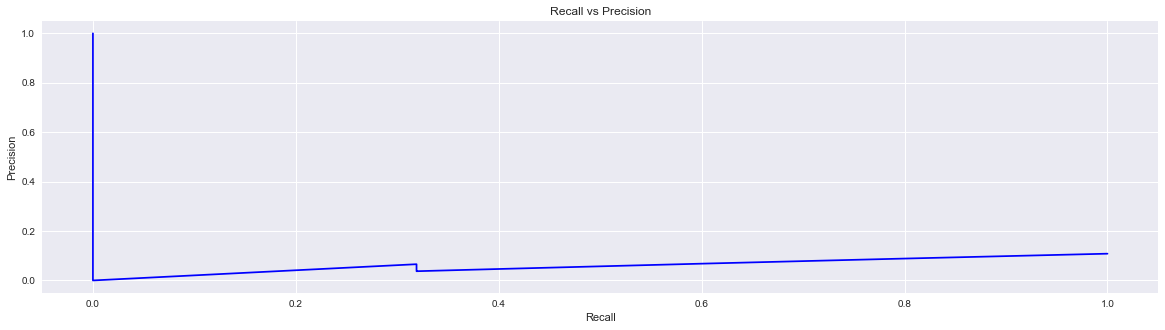

In [33]:
precision, recall, th = precision_recall_curve(error_time_df.TimeLabel, error_time_df.Error, pos_label=1)
plt.figure(figsize=(20, 5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [34]:
time_threshold = np.mean(error_time_df['Error'])
print('Threshold of Time: {}'.format(time_threshold))

Threshold of Time: 0.5589916195456461


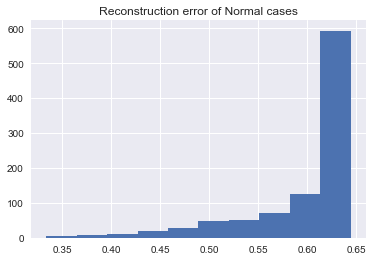

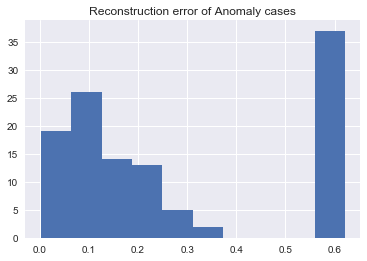

In [35]:
plotReconstructionError(error_time_df, variable='Time')

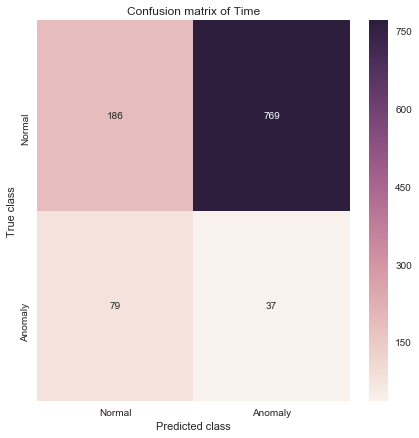

In [36]:
plotConfusionMaxtrix(error_time_df, threshold=time_threshold, variable='Time')

In [37]:
evalScore(error_time_df, threshold=time_threshold, variable='Time')

-------Evaluation of Time-------


--Weighted Evaluation--
Evaluation of Time
Precision: 0.63
Recall: 0.21
Fscore: 0.28


--Evaluation for each class--
Normal
Precision: 0.70
Recall: 0.19
Fscore: 0.30


Anomaly
Precision: 0.05
Recall: 0.32
Fscore: 0.08


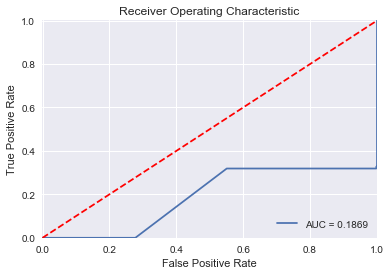

In [38]:
fpr, tpr, thresholds = roc_curve(error_time_df.TimeLabel, error_time_df.Error, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [39]:
#get submission
inverse_normalized_time = [x*(max_value-min_value)+min_value for x in fixed_predicted_time]
predicted_time_label_test = [1 if e > time_threshold else 0 for e in error_time_df.Error.values]

submission_time = pd.DataFrame({'CumDuration': true_cumduration_test,
                                'AnomalousCumDuration': anomalous_cumduration_test,
                                'PredictedCumDuration': inverse_normalized_time,
                                'TimeLabel': time_label_test,
                                'PredictedTimeLabel': predicted_time_label_test,
                                'Activity': true_activity_test})

In [40]:
submission_time.head()

,Activity,AnomalousCumDuration,CumDuration,PredictedCumDuration,PredictedTimeLabel,TimeLabel
5589,Accepted-In Progress,0.000000e+00,0.0,0.000000e+00,1,0
5590,Completed-Closed,2.641088e+07,3021109.0,1.394694e+08,0,1
5591,Accepted-In Progress,0.000000e+00,0.0,0.000000e+00,1,0
5592,Completed-Closed,4.212961e+06,4212961.0,5.597141e+06,0,0
5593,Accepted-In Progress,0.000000e+00,0.0,0.000000e+00,1,0


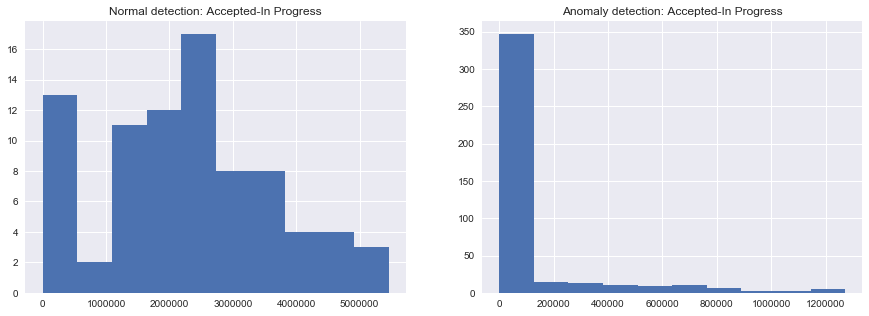

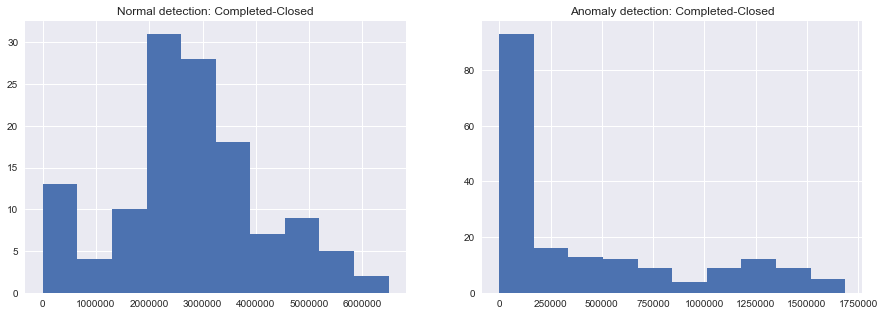

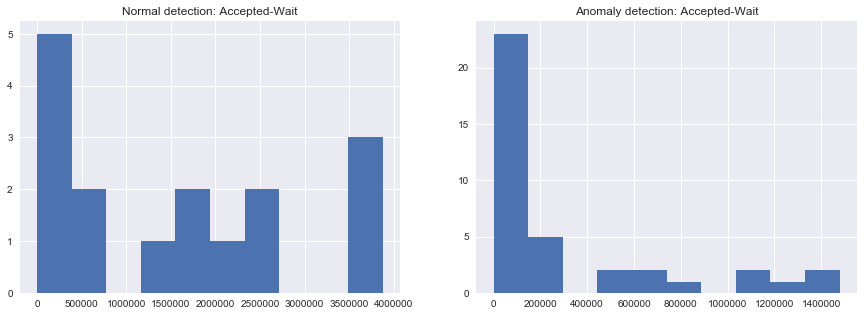

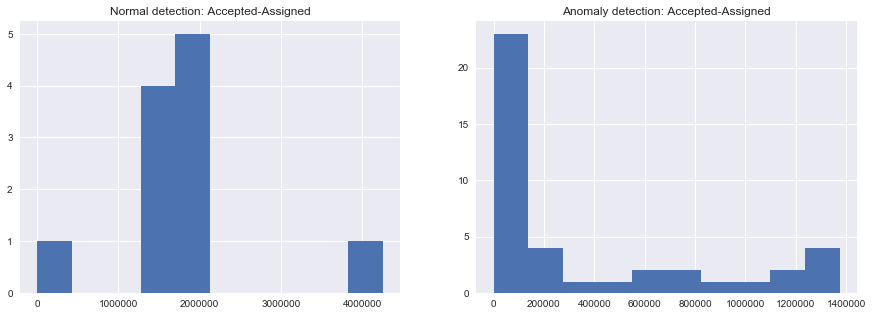

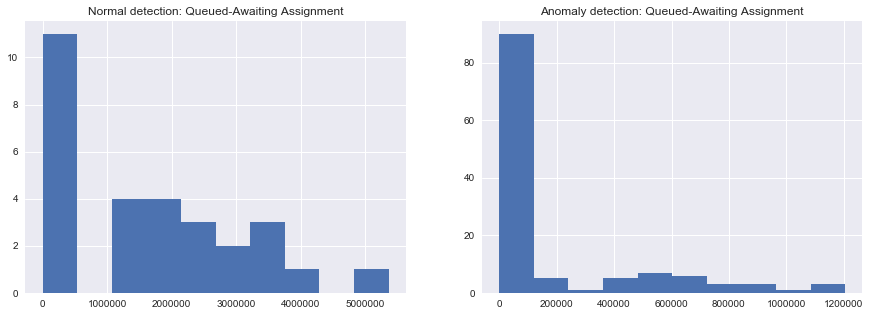

In [41]:
predicted_normal_df = submission_time[(submission_time['PredictedTimeLabel']== 0)]
predicted_anomaly_df = submission_time[(submission_time['PredictedTimeLabel']== 1)]

act_list = submission_time['Activity'].unique()

for act in act_list:
    plotDuration(predicted_normal_df, predicted_anomaly_df, act)

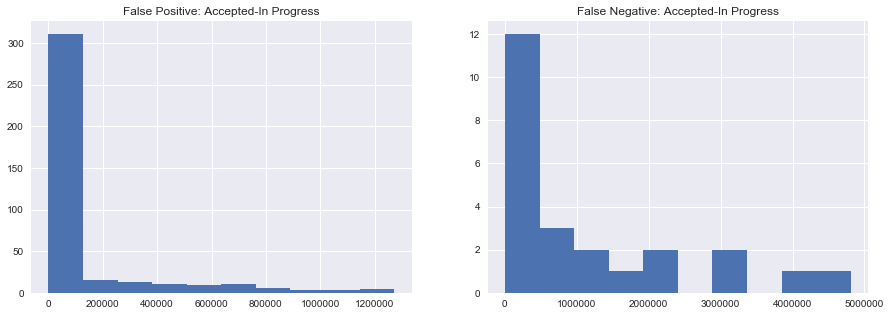

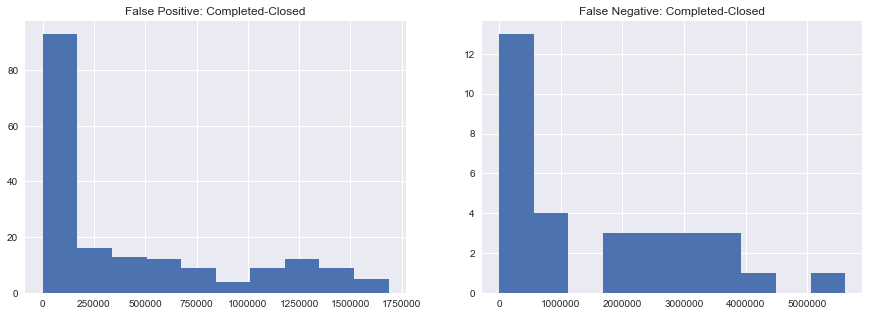

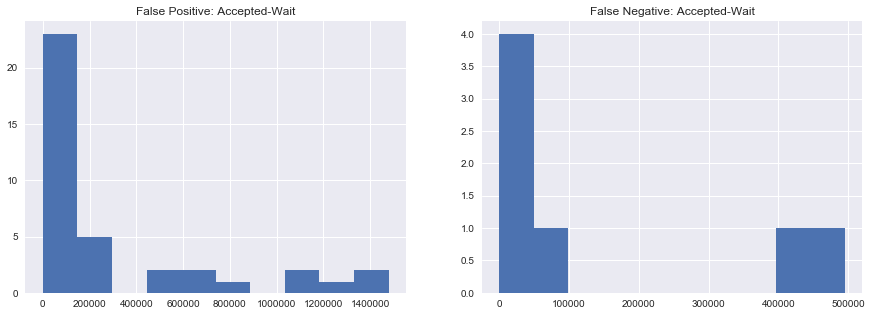

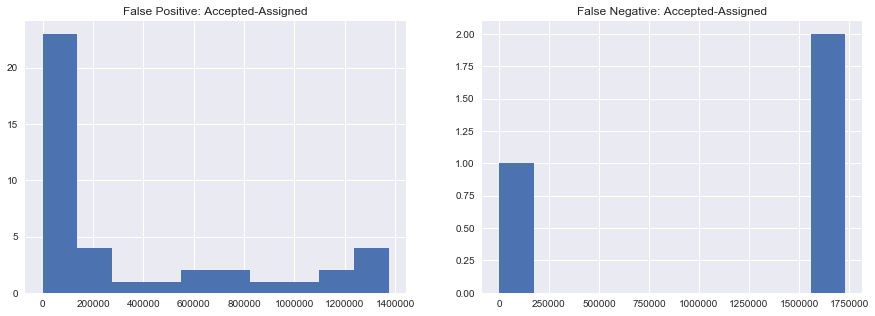

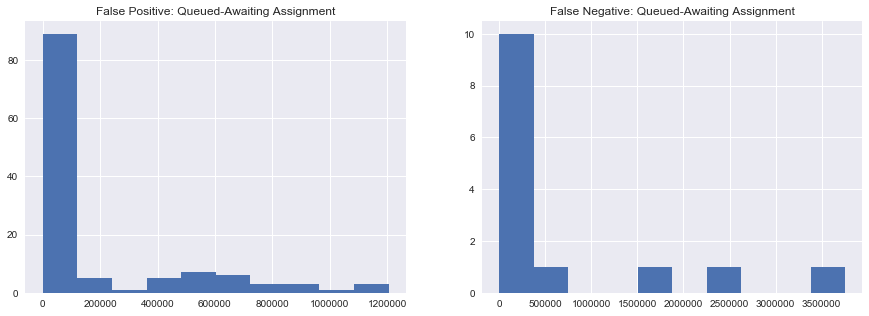

In [42]:
false_positive_df = submission_time[(submission_time['PredictedTimeLabel']== 1)&(submission_time['TimeLabel']== 0)]
false_negative_df = submission_time[(submission_time['PredictedTimeLabel']== 0)&(submission_time['TimeLabel']== 1)]

for act in act_list:
    plotFalseDuration(false_positive_df, false_negative_df, act)

## Activity

In [43]:
error = np.mean(np.power(true_activity - predicted_activity, 2), axis = 1)
error_activity_df = pd.DataFrame({'Error': error,
                                  'ActivityLabel': activity_label_test})

In [44]:
error_activity_df.head()

,ActivityLabel,Error
5589,0,0.081952
5590,0,0.084250
5591,0,0.081952
5592,0,0.084763
5593,1,0.123008


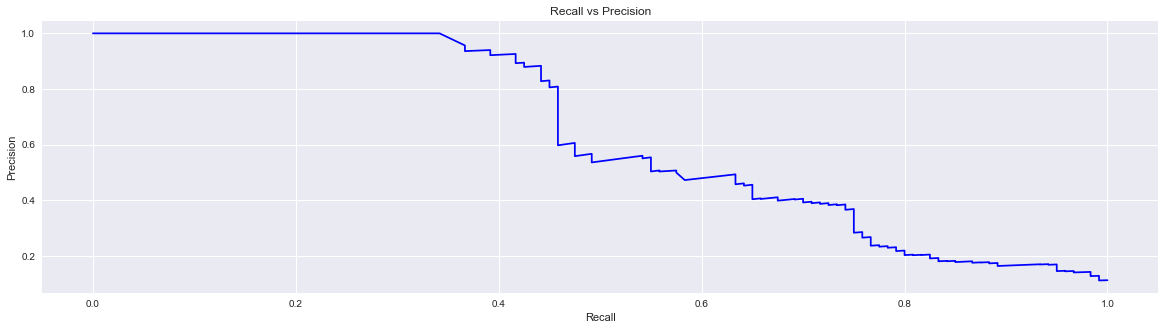

In [45]:
precision, recall, th = precision_recall_curve(error_activity_df.ActivityLabel, error_activity_df.Error, pos_label=1)
plt.figure(figsize=(20, 5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [46]:
activity_threshold = np.mean(error_activity_df['Error'])
print('Threshold of Activity: {}'.format(activity_threshold))

Threshold of Activity: 0.08805113755522656


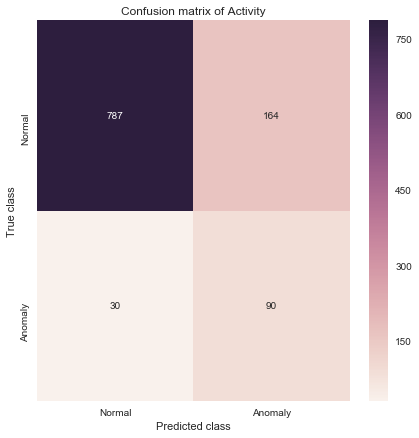

In [47]:
plotConfusionMaxtrix(error_activity_df, activity_threshold, variable='Activity')

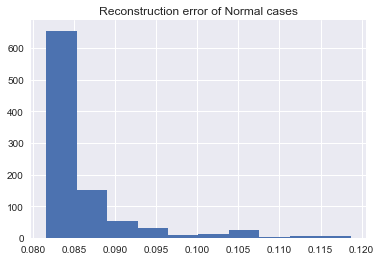

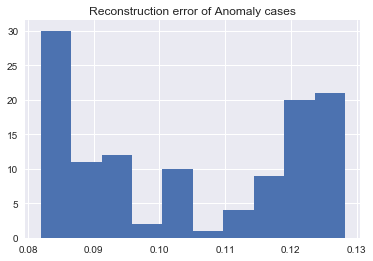

In [48]:
plotReconstructionError(error_activity_df)

In [51]:
evalScore(error_activity_df, activity_threshold, variable='Activity')

-------Evaluation of Activity-------


--Weighted Evaluation--
Evaluation of Activity
Precision: 0.90
Recall: 0.82
Fscore: 0.84


--Evaluation for each class--
Normal
Precision: 0.96
Recall: 0.83
Fscore: 0.89


Anomaly
Precision: 0.35
Recall: 0.75
Fscore: 0.48


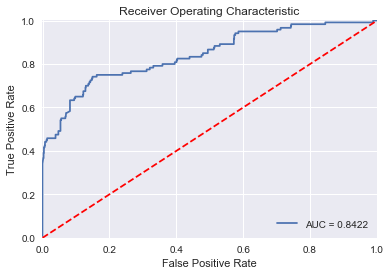

In [50]:
fpr, tpr, thresholds = roc_curve(error_activity_df.ActivityLabel, error_activity_df.Error, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();